## 1. Import Modules and Data

This script processes a corpus to prepare data for BERT-style training. The dataset is implemented in the **BERTDataset** class, which reads and tokenizes text, generates masked tokens for training, and creates segment labels. The vocabulary is
imported in advance from huggingface's model library.


The corpus is first loaded from a text file, where each line consists of two tab-separated sentences. Here I load the first parquet file of datasets **Bookcorpus** and **Wikipedia(20231101.en)** to create a txt file named corpus.txt.

The dataset supports both memory-based and file-streaming modes. The **random_word** function randomly replaces words with mask tokens for masked language modeling(MLM), while **random_sent** generates paired sentences for next-sentence prediction(NSP).

In [2]:
import data
from torch.utils.data import DataLoader
import config
# load BookCorpus and English Wikipedia
data.load_bookcorpus_wikipedia(0.1, 1/41)

print("Loading train dataset done")

Loading train dataset done


[nltk_data] Downloading package punkt to /home/bks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/bks/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
from transformers import AutoTokenizer
from data import BERTDataset

tokenizer = AutoTokenizer.from_pretrained(config.pretrained_path)

print("Loading Train Dataset", config.train_dataset)
train_dataset = BERTDataset(config.train_dataset, tokenizer, seq_len=config.sequence_length,
                            corpus_lines=config.corpus_lines, on_memory=config.on_memory, loading_ratio=0.000002)
print("Train Dataset Size: ", len(train_dataset))

print("Loading Test Dataset", config.test_dataset)
test_dataset = BERTDataset(config.test_dataset, tokenizer, seq_len=config.sequence_length, on_memory=config.on_memory,loading_ratio=0.000002) \
    if config.test_dataset is not None else None

print("Creating Dataloader")
train_data_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers)
test_data_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=config.num_workers) \
    if test_dataset is not None else None


Loading Train Dataset /home/bks/lzh/dataset/corpus.txt
num_load_lines: 22


Loading Dataset: 100%|██████████| 22/22 [00:00<00:00, 198014.35it/s]

length of self.lines: 22
Train Dataset Size:  22
Loading Test Dataset None
Creating Dataloader


## 2. Build Model
Build the model

In [4]:
from modules.bert import BertForPreTraining

print("Building BERT model")
bert = BertForPreTraining(
    config.vocab_size,
    hidden_size=config.hidden_size,
    num_hidden_layers=config.num_layers,
    num_attention_heads=config.attention_heads
)
print(bert)

Building BERT model
BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): ModuleDict(
            (self): SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ModuleDict(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)

## 3. Train Model
Here I define a BERTTrainer class for pretraing settings.

In [5]:
import torch
import torch.nn as nn
import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from modules import BertForPreTraining

class BERTTrainer:
    """
    BERTTrainer make the pretrained BERT model with two LM training method.

        1. Masked Language Model : 3.3.1 Task #1: Masked LM
        2. Next Sentence prediction : 3.3.2 Task #2: Next Sentence Prediction

    please check the details on README.md with simple example.

    """
    def __init__(
            self, 
            bert: BertForPreTraining,
            train_dataloader: DataLoader, 
            test_dataloader: DataLoader = None,
            lr: float = 1e-4, 
            betas=(0.9, 0.999), 
            weight_decay: float = 0.01, 
            warmup_steps=10000,
            total_steps=1000000,
            with_cuda: bool = True, 
            log_freq: int = 10):
        """
        :param bert: BERT model which you want to train
        :param train_dataloader: train dataset data loader
        :param test_dataloader: test dataset data loader [can be None]
        :param lr: learning rate of optimizer
        :param betas: Adam optimizer betas
        :param weight_decay: Adam optimizer weight decay param
        :param with_cuda: traning with cuda
        :param log_freq: logging frequency of the batch iteration
        """

        # Setup cuda device for BERT training, argument -c, --cuda should be true
        cuda_condition = torch.cuda.is_available() and with_cuda
        self.device = torch.device("cuda:0" if cuda_condition else "cpu")

        # This BERT model will be saved every epoch
        self.bert = bert
        # Initialize the BERT Language Model, with BERT model
        self.model = bert.to(self.device)

        # Distributed GPU training if CUDA can detect more than 1 GPU
        # if with_cuda and torch.cuda.device_count() > 1:
        #     print("Using %d GPUS for BERT" % torch.cuda.device_count())
        #     self.model = nn.DataParallel(self.model, device_ids=cuda_devices)

        # Setting the train and test data loader
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optimizer = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = nn.NLLLoss(ignore_index=0)

        self.log_freq = log_freq

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        """
        loop over the data_loader for training or testing
        if on train status, backward operation is activated
        and also auto save the model every epoch

        :param epoch: current epoch index
        :param data_loader: torch.utils.data.DataLoader for iteration
        :param train: boolean value of is train or test
        :return: None
        """
        str_code = "train" if train else "test"

        # Setting the tqdm progress bar
        data_iter = tqdm.tqdm(enumerate(data_loader),
                              desc="EP_%s:%d" % (str_code, epoch),
                              total=len(data_loader),
                              bar_format="{l_bar}{r_bar}")

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        for i, data in data_iter:
            # get batch data
            data = {key: value.to(self.device) for key, value in data.items()}

            outputs = self.model.forward(
                input_ids=data["bert_input"],
                attention_mask=data["bert_attention_mask"],
                token_type_ids=data["segment_label"],
                labels=data["bert_label"],
                next_sentence_label=data["is_next"]
            )
            total_loss, prediction_scores, seq_relationship_score = outputs
            # backward and optimization only in train
            if train:
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            # next sentence prediction accuracy
            correct = seq_relationship_score.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += total_loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": total_loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))

        print("EP%d_%s, avg_loss=" % (epoch, str_code), avg_loss / len(data_iter), "total_acc=",
              total_correct * 100.0 / total_element)

    def save(self, epoch, file_path):
        """
        Saving the current BERT model on file_path

        :param epoch: current epoch number
        :param file_path: model output path which gonna be file_path+"ep%d" % epoch
        :return: final_output_path
        """
        output_path = str(file_path) + "_ep%d.pth" % epoch
        torch.save(self.bert.cpu(), output_path)
        self.bert.to(self.device)
        print("EP:%d Model Saved on:" % epoch, output_path)
        return output_path
    
trainer = BERTTrainer(
    bert,
    train_dataloader=train_data_loader, 
    test_dataloader=test_data_loader,       
    lr=config.learning_rate,     
    betas=(config.adam_beta1, config.adam_beta2),
    weight_decay=config.adam_weight_decay,
    warmup_steps=config.warmup_steps,
    total_steps = config.total_steps,
    with_cuda=config.with_cuda, 
    log_freq=config.log_freq
)

Total Parameters: 110106428


### 3.1 Optimizer and Scheduler
Original paper shows that they use Adam with learning rate of 1e-4, β1 = 0.9, β2 = 0.999, L2 weight decay of 0.01, learning rate warmup over the first 10,000 steps, and linear decay of the learning rate in the pretraining

Thus I use Adam optimizer with the same hyper-parameters, and get_linear_schedule_with_warmup function from transformers library to create the learning rate scheduler.

The learing rate schedule is shown as below. The initial value is 1e-4.

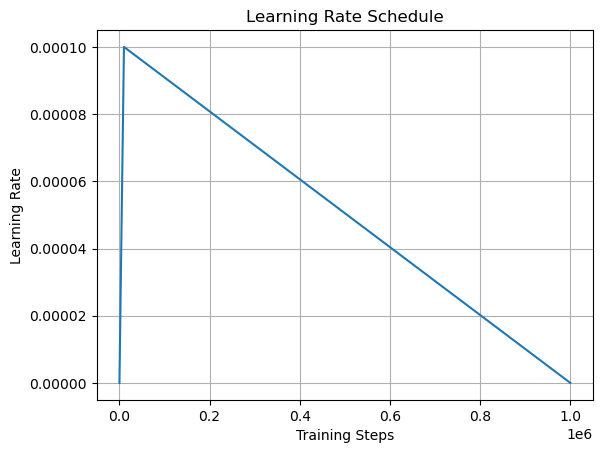

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
import config

# Randomly create a model
test_model = torch.nn.Linear(10, 1)

# Create optimizer
optimizer = Adam(
    test_model.parameters(),
    lr=config.learning_rate,
    betas=(config.adam_beta1, config.adam_beta2),
    weight_decay=config.adam_weight_decay
)

# Create the learning rate scheduler using transformers' get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_training_steps=config.total_steps,  # Total number of training steps
    num_warmup_steps=config.warmup_steps,    # Number of warmup steps
)

lr_values = []

# Loop through training steps
for _ in range(config.total_steps):
    # Update lr
    optimizer.step()
    lr_values.append(scheduler.get_last_lr())
    scheduler.step()

# Plot the learning rate curve
plt.plot(lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


### 3.2 Train loop
Simple test of pretraining process.

In [6]:
print("Training Start")
for epoch in range(config.epochs):
    trainer.train(epoch)
    if epoch % config.log_freq == 0:
        trainer.save(epoch, config.trained_path)
    if test_data_loader is not None:
        trainer.test(epoch)

Training Start


EP_train:0:  27%|| 3/11 [00:01<00:02,  3.00it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.511968612670898, 'avg_acc': 100.0, 'loss': 11.511968612670898}


EP_train:0:  82%|| 9/11 [00:01<00:00,  8.97it/s]

{'epoch': 0, 'iter': 5, 'avg_loss': 11.693164825439453, 'avg_acc': 50.0, 'loss': 11.782041549682617}


EP_train:0: 100%|| 11/11 [00:01<00:00,  5.89it/s]


{'epoch': 0, 'iter': 10, 'avg_loss': 11.638592720031738, 'avg_acc': 59.09090909090909, 'loss': 11.53420352935791}
EP0_train, avg_loss= 11.638592720031738 total_acc= 59.09090909090909
EP:0 Model Saved on: /home/bks/lzh/checkpoints/bert_self_trained_ep0.pth


EP_train:1:  27%|| 3/11 [00:00<00:00, 11.52it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 11.633398056030273, 'avg_acc': 50.0, 'loss': 11.633398056030273}


EP_train:1:  82%|| 9/11 [00:00<00:00, 14.79it/s]

{'epoch': 1, 'iter': 5, 'avg_loss': 11.564441521962484, 'avg_acc': 66.66666666666666, 'loss': 11.521570205688477}


EP_train:1: 100%|| 11/11 [00:00<00:00, 11.90it/s]

{'epoch': 1, 'iter': 10, 'avg_loss': 11.480820222334428, 'avg_acc': 54.54545454545454, 'loss': 11.199502944946289}
EP1_train, avg_loss= 11.480820222334428 total_acc= 54.54545454545455



EP_train:2:  27%|| 3/11 [00:00<00:00, 13.08it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 11.45975399017334, 'avg_acc': 0.0, 'loss': 11.45975399017334}


EP_train:2:  82%|| 9/11 [00:00<00:00, 15.05it/s]

{'epoch': 2, 'iter': 5, 'avg_loss': 11.160041014353434, 'avg_acc': 50.0, 'loss': 11.001148223876953}


EP_train:2: 100%|| 11/11 [00:00<00:00, 12.34it/s]

{'epoch': 2, 'iter': 10, 'avg_loss': 11.023141774264248, 'avg_acc': 54.54545454545454, 'loss': 10.763666152954102}
EP2_train, avg_loss= 11.023141774264248 total_acc= 54.54545454545455



EP_train:3:  18%|| 2/11 [00:00<00:00, 12.31it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 10.7632417678833, 'avg_acc': 50.0, 'loss': 10.7632417678833}


EP_train:3:  73%|| 8/11 [00:00<00:00, 15.04it/s]

{'epoch': 3, 'iter': 5, 'avg_loss': 10.52497657140096, 'avg_acc': 58.333333333333336, 'loss': 10.387877464294434}


EP_train:3: 100%|| 11/11 [00:00<00:00, 11.74it/s]

{'epoch': 3, 'iter': 10, 'avg_loss': 10.382498654452236, 'avg_acc': 45.45454545454545, 'loss': 10.135360717773438}
EP3_train, avg_loss= 10.382498654452236 total_acc= 45.45454545454545



EP_train:4:  27%|| 3/11 [00:00<00:00, 11.53it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 9.780165672302246, 'avg_acc': 100.0, 'loss': 9.780165672302246}


EP_train:4:  82%|| 9/11 [00:00<00:00, 14.84it/s]

{'epoch': 4, 'iter': 5, 'avg_loss': 9.686190605163574, 'avg_acc': 75.0, 'loss': 9.539986610412598}


EP_train:4: 100%|| 11/11 [00:00<00:00, 11.91it/s]

{'epoch': 4, 'iter': 10, 'avg_loss': 9.480205015702682, 'avg_acc': 59.09090909090909, 'loss': 9.070290565490723}
EP4_train, avg_loss= 9.480205015702682 total_acc= 59.09090909090909
